# Update Point Geometry Using Address Field

Example: We have 13 points (collected in survey123) that have the correct address entered in a field called Address but incorrect point locations. (wrong SHAPE).

This screenshot shows a sample output where the 13 points on the left (all stacked on top of each other) have been corrected to the locations on the right.

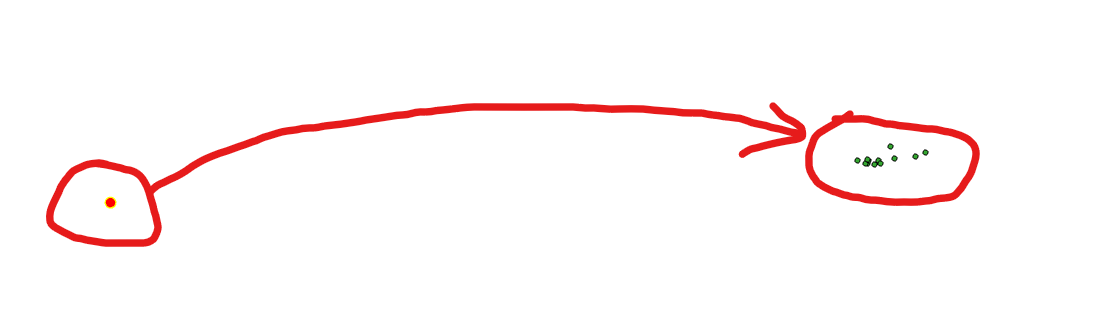


1. Convert to table. To Geocode addresses the data must be in a table. Use the Export Table tool
https://pro.arcgis.com/en/pro-app/latest/tool-reference/conversion/export-table.htm

2. Use Geocode Address tool. 
https://pro.arcgis.com/en/pro-app/latest/tool-reference/geocoding/geocode-addresses.htm

3. Update the SHAPE field using an update cursor
Credit: JohannesLindner https://community.esri.com/t5/attribute-rules-questions/how-to-update-geometry-based-on-attribute-values/td-p/426111


#### *Note: This notebooks is intended to be used in an active arcPro session. The Geocode Address tool uses credits.

In [ ]:
import arcpy
arcpy.env.workspace = r"memory"
arcpy.env.overwriteOutput = True 
arcpy.env.addOutputsToMap = True  
active_map = arcpy.mp.ArcGISProject("current").activeMap


In [ ]:
arcpy.conversion.ExportTable(
    in_table="surveyselection",
    out_table=r"surveyselection_ExportTable",
    where_clause="",
    use_field_alias_as_name="NOT_USE_ALIAS",
    sort_field=None
)

In [ ]:
'''
******************NOTE!*************
Performing geocoding operations using the ArcGIS World Geocoding Service 
requires an ArcGIS organizational account, and it consumes credits. 
The organizational account must have enough credits to complete the entire geocoding request.

'''

arcpy.geocoding.GeocodeAddresses(
    in_table="surveyselection_ExportTable",
    address_locator="https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/Esri World Geocoder",
    in_address_fields="'Single Line Input' address VISIBLE NONE",
    out_feature_class=r"surveyselection_Geocode",
    out_relationship_type="STATIC",
    country=None,
    location_type="ADDRESS_LOCATION",
    category="Subaddress;'Point Address';'Street Address';'Distance Marker';Intersection;'Street Midblock';'Street Between';'Street Name'",
    output_fields="ALL"
)

In [ ]:
geometry_layer = "surveyselection_Geocode"
attribute_layer = "surveyselection"

#the geocoder address USER_ to all of our existing fields
geometry_layer_join_field = "USER_address"
attribute_layer_join_field = "address"

# this will change the geometry of the second layer's underlying data, so back it up!

##Option to grab layers from activeMap
# active_map = arcpy.mp.ArcGISProject("current").activeMap
# geometry_layer = active_map.listLayers(geometry_layer_name)[0]
# attribute_layer = active_map.listLayers(attribute_layer_name)[0]


# read the correct geometries and save them in a dictionary
# {common_field_value: shape}
cursor = arcpy.da.SearchCursor(geometry_layer, [geometry_layer_join_field, "SHAPE@"])
shapes = dict([row for row in cursor])




'''
In some cases you may need to start an edit session.

The following includes some dataset types that can only be edited within an edit session:

Feature classes participating in a topology
Feature classes participating in a geometric network
Feature classes participating in a network dataset
Versioned datasets in enterprise geodatabases
Some object and feature classes with class extensions
'''

# workspace = arcpy.env.workspace
# # Start an edit session
# edit = arcpy.da.Editor(workspace)
# edit.startEditing(False, True)  # Start with undo/redo capability




# loop through the second layer and update the geometries
updated_features = []
with arcpy.da.UpdateCursor(attribute_layer, [attribute_layer_join_field, "SHAPE@"]) as cursor:
    for row in cursor:
        try:
            new_shape = shapes[row[0]]
            # only update if the geometry is different, fill the updated_features list
            if not new_shape.equals(row[1]):
                cursor.updateRow([row[0], new_shape])
                updated_features.append(row[0])
        except KeyError:
            print("No new geometry found for feature with {} = {}".format(attribute_layer_join_field, row[0]))
   


        
'''
if you use an edit session, use this to stop and save edits
'''        
# # Stop the edit session
# edit.stopEditing(True)  # Save edits          




# build an SQL query of the updated_features, depending on whether common_field is a text field or not
if updated_features and isinstance(updated_features[0], str):
    sql = "{} IN ('{}')".format(attribute_layer_join_field, "', '".join(updated_features))
else:
    sql = "{} IN ({})".format(attribute_layer_join_field, ", ".join([str(uf) for uf in updated_features]))
# print the SQL query
print("Updated the geometry of {} features:\n{}".format(len(updated_features), sql))

